# CONUS Domain

In [1]:
import sys
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import netCDF4 as nc

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import preprocess_utils as pu

### Import raw XLAT XLON

In [4]:
date_str = '2010102400/'
nc_files = sorted(glob(NCAR500_dir+date_str+'*.nc'))

In [5]:
with nc.Dataset(nc_files[0], 'r') as ncio:
    XLAT = ncio['XLAT'][0, ...]
    XLON = ncio['XLONG'][0, ...]

In [6]:
grid_shape = XLON.shape

### Domain creation

Old scripts that run on odd number of gaps only

In [7]:
# def domain_centerp_2d(data, gap):
#     '''
#     '''
    
#     assert gap >= 3
#     assert gap % 2 == 1
    
#     grid_shape = data.shape
#     gap_mid = (gap-1) // 2
#     gap_mid_double = 2*gap_mid
    
#     Nx = grid_shape[0] // gap_mid_double + 1
#     Ny = grid_shape[1] // gap_mid_double + 1
    
#     edgex = gap_mid+gap_mid_double*(Nx-1)
#     edgey = gap_mid+gap_mid_double*(Ny-1)
    
#     if (edgex+gap_mid > grid_shape[0]):
#         Nx -= 1
    
#     if (edgey+gap_mid > grid_shape[1]):
#         Ny -= 1
        
#     out = np.empty((Nx, Ny))
    
#     for ix in range(Nx):
#         for iy in range(Ny):
#             out[ix, iy] = data[gap_mid+gap_mid_double*ix, gap_mid+gap_mid_double*iy]
#     return out

# def domain_aggregate_2d(data, gap, method='mean'):
#     '''
#     '''
    
#     assert gap >= 3
#     assert gap % 2 == 1
#     assert method in ['mean', 'min', 'max']
    
#     grid_shape = data.shape
#     gap_mid = (gap-1) // 2
    
#     gap_mid_double = 2*gap_mid
    
#     Nx = grid_shape[0] // gap_mid_double + 1
#     Ny = grid_shape[1] // gap_mid_double + 1
    
#     edgex = gap_mid+gap_mid_double*(Nx-1)
#     edgey = gap_mid+gap_mid_double*(Ny-1)
    
#     if (edgex+gap_mid > grid_shape[0]):
#         Nx -= 1
    
#     if (edgey+gap_mid > grid_shape[1]):
#         Ny -= 1
        
#     out = np.empty((Nx, Ny))
    
#     for ix in range(Nx):
#         for iy in range(Ny):
#             if method == 'mean':
#                 out[ix, iy] = np.nanmean(data[ix*gap_mid_double:(ix+1)*gap_mid_double, iy*gap_mid_double:(iy+1)*gap_mid_double])
#             elif method == 'min':
#                 out[ix, iy] = np.nanmin(data[ix*gap:(ix+1)*gap, iy*gap:(iy+1)*gap])
#             else:
#                 out[ix, iy] = np.nanmax(data[ix*gap:(ix+1)*gap, iy*gap:(iy+1)*gap])
#     return out

In [8]:
def domain_aggregate_2d(data, gap, method='mean'):
    assert gap >= 2
    assert method in ['mean', 'min', 'max']
    
    Nx = grid_shape[0] // gap + 1
    Ny = grid_shape[1] // gap + 1
    
    edgex = gap*Nx
    edgey = gap*Ny
    
    if (edgex > grid_shape[0]+1):
        Nx -= 1
    
    if (edgey > grid_shape[1]+1):
        Ny -= 1
        
    out = np.empty((Nx, Ny))
    
    for ix in range(Nx):
        for iy in range(Ny):
            if method == 'mean':
                out[ix, iy] = np.nanmean(data[ix*gap:(ix+1)*gap, iy*gap:(iy+1)*gap])
            elif method == 'min':
                out[ix, iy] = np.nanmin(data[ix*gap:(ix+1)*gap, iy*gap:(iy+1)*gap])
            else:
                out[ix, iy] = np.nanmax(data[ix*gap:(ix+1)*gap, iy*gap:(iy+1)*gap])
    return out

In [9]:
lon = domain_aggregate_2d(XLON, gap=24) # grid spacing = 24*3 = 72 km
lat = domain_aggregate_2d(XLAT, gap=24)

# lon_test = domain_aggregate_2d(XLON, gap=72)
# lat_test = domain_aggregate_2d(XLAT, gap=72)

### Visual testing

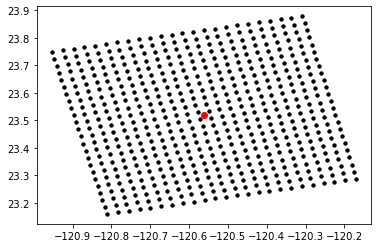

In [10]:
plt.plot(XLON[:24, :24], XLAT[:24, :24], 'k.');
plt.plot(XLON[:24, :24].T, XLAT[:24, :24].T, 'k.');

plt.plot(lon[0, 0], lat[0, 0], 'ro')

In [11]:
# def frame_selector(data, xi, yi, gap_target, N_range_encode):
#     '''
#     Selecting [gap_target*N_range_encode] sized patches from 3-km model run
#     '''
#     assert N_range_encode % 2 == 1
#     N_range_half = (N_range_encode - 1) // 2 # half of the encoded target grids
#     gap_encode_left = gap_target*N_range_half # left side of the encoded target grids converted to model grids
#     gap_encode_right = gap_target*N_range_half+gap_target # right side of the encoded target grids converted to model grids
#     return data[xi*gap_target-gap_encode_left:xi*gap_target+gap_encode_right, yi*gap_target-gap_encode_left:yi*gap_target+gap_encode_right]

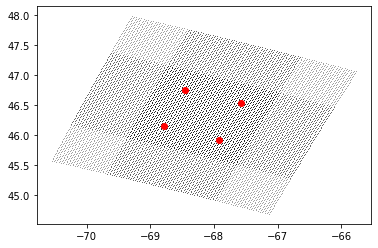

In [18]:
grid_shape_72 = lon.shape

gap_target = 24 # target is defined on 24-by-24 model grids 

N_range_encode = 3 # Encoder takes 3-by-3 target grids; it must be an odd number

# for xi in range(1, grid_shape_72[0]-1, 1):
#     for yi in range(1, grid_shape_72[1]-1, 1):

for xi in range(38, grid_shape_72[0]-1, 1):
    for yi in range(62, grid_shape_72[1]-1, 1):
        plt.plot(pu.frame_selector(XLON, xi, yi, gap_target, N_range_encode), 
                 pu.frame_selector(XLAT, xi, yi, gap_target, N_range_encode), 'k.', ms=1.0, mew=0, zorder=1)
        plt.plot(lon[xi, yi], lat[xi, yi], 'ro', zorder=3);

## ========================================================================== #
## This is how to accept 72-km inputs of 3-km grids and produce 24 km outputs 
# output[xi, yi] = CNN(pu.frame_selector(data, xi, yi, gap_target, N_range_encode))

In [14]:
pu.frame_selector(XLON, xi, yi, gap_target, N_range_encode).shape

(72, 72)

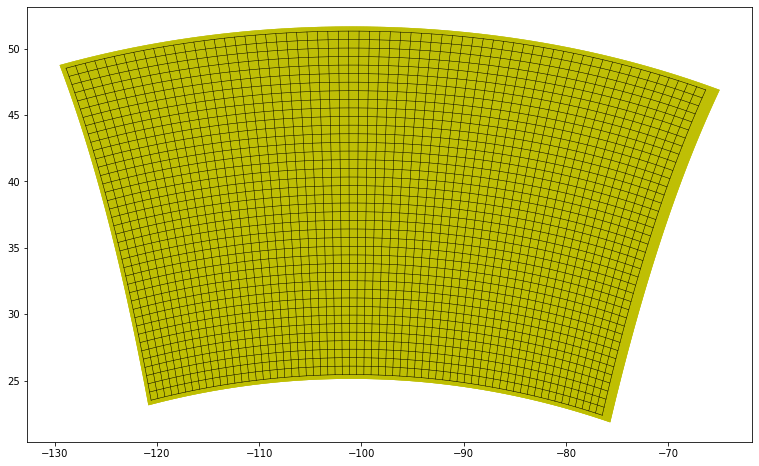

In [15]:
plt.figure(figsize=(13, 8))

plt.plot(XLON, XLAT, 'y-', lw=0.5);
plt.plot(XLON.T, XLAT.T, 'y-', lw=0.5);

plt.plot(lon, lat, 'k-', lw=0.5);
plt.plot(lon.T, lat.T, 'k-', lw=0.5);

In [16]:
save_dir = '/glade/work/ksha/NCAR/'
tuple_save = (lon, lat, XLON, XLAT)
label_save = ['lon_72km', 'lat_72km', 'lon_3km', 'lat_3km']
du.save_hdf5(tuple_save, label_save, save_dir, 'CONUS_domain.hdf')

Save to /glade/work/ksha/NCAR/CONUS_domain.hdf
